# 비지도학습 - 주성분 분석(pca), NMF, 클러스터링

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### test에 fit하면 안 되는 이유

##### 데이터 준비

In [2]:
# 데이터 준비
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

X, y = make_blobs(n_samples=50, centers=5, random_state=42, cluster_std=2) # cluster_std 그룹내 표준편차
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# test는 fit하면 안된다. fit했을때 생기는 문제는?
mms_train = MinMaxScaler()
mms_test = MinMaxScaler()
X_train_scaled = mms_train.fit_transform(X_train)
X_test_scaled1 = mms_test.fit_transform(X_test)
X_test_scaled2 = mms_train.transform(X_test)


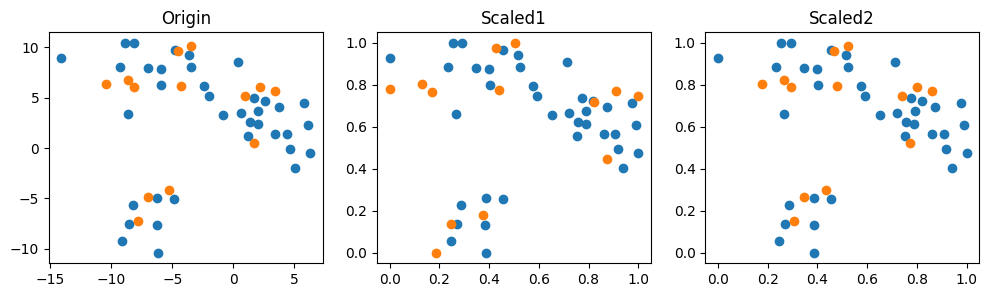

In [3]:
# 1행 3열 그래프 만들기
fig, axes = plt.subplots(1, 3, figsize=(12,3))     # axes 배열들어간다

axes[0].scatter(X_train[:, 0], X_train[:, 1])
axes[0].scatter(X_test[:, 0], X_test[:, 1])
axes[0].set_title("Origin")

axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1])
axes[1].scatter(X_test_scaled1[:, 0], X_test_scaled1[:, 1])
axes[1].set_title("Scaled1")

axes[2].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1])
axes[2].scatter(X_test_scaled2[:, 0], X_test_scaled2[:, 1])
axes[2].set_title("Scaled2")

plt.show()

# 스케일 전 후 오렌지와 파랑의 위치는 동일해야한다
# 근데 test를 fit하면 scaled1처럼 위치가 달라진다 > 기준이 달라진다.

### 주성분분석(PCA)

##### 데이터 준비

In [4]:
from sklearn.datasets import load_breast_cancer

bc_dataset = load_breast_cancer()
X = bc_dataset['data']
y = bc_dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


##### 특성별 설명력 시각화

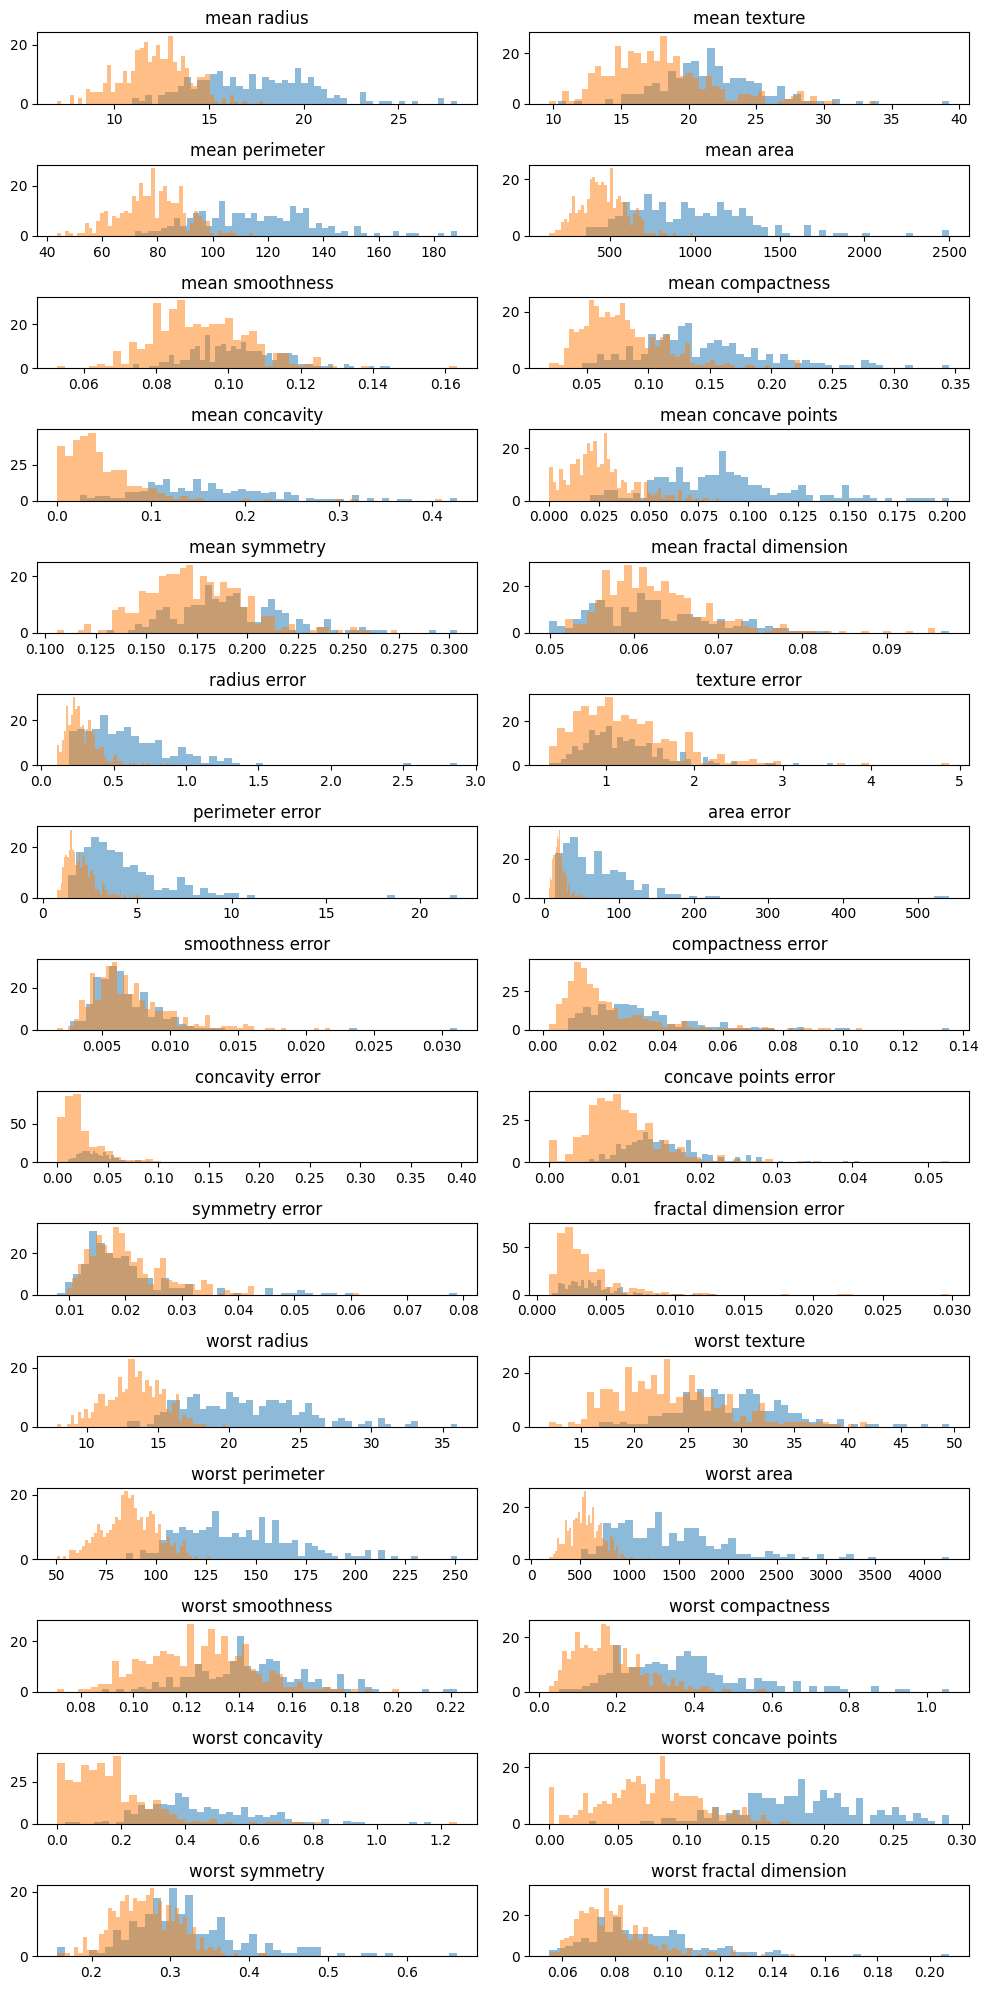

In [5]:
fig, axes = plt.subplots(15, 2, figsize=(10, 20))   # 서브플롯 15행 2열
axes = axes.flatten()   # flatten: n차원(지금: 15행 2열) -> 1차원 변환(30)
for idx, ax in enumerate(axes):
    ax.hist(X[y==0, idx], bins=50, alpha=0.5)
    ax.hist(X[y==1, idx], bins=50, alpha=0.5)
    ax.set_title(bc_dataset['feature_names'][idx])

fig.tight_layout()
plt.show()

# 속성이 구분을 잘하는지 그래프로 확인
# 서로 겹친 정도가 심한 것은 설명력이 떨어짐 > 버려도 된다.
# 서로 독립적 이라면 설명이 가능하다

##### PCA 적용

차원 축소

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

ssc = StandardScaler()
X_train_scaled = ssc.fit_transform(X_train)   # PCA를 적용하기 전에 정규분포로 변환하는 것을 권장

pca = PCA(n_components=2)   # n_components: 사용할 속성 수 (차원 수) 설정
# pca = PCA(n_components=5)
# pca = PCA(n_components=10)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)

X_train.shape, X_train_pca.shape
# >((426, 30), (426, 2)) > 30차원이 2차원 됨

((426, 30), (426, 2))

차원 축소하지 않은 것(특성 30개)과 축소한 것(특성 2/5/10개)의 설명력 비교

In [7]:
from sklearn.linear_model import LogisticRegression

# 차원 축소 전후 설명력 비교
logreg1 = LogisticRegression(max_iter=10000)
logreg1.fit(X_train_scaled, y_train)
logreg2 = LogisticRegression(max_iter=10000)
logreg2.fit(X_train_pca, y_train)

logreg1.score(X_train_scaled, y_train), logreg2.score(X_train_pca, y_train)
# (0.9882629107981221, 0.9624413145539906) 0.02 정도의 차이 > 뛰어난 성능 > 가성비 좋음

(0.9882629107981221, 0.9624413145539906)

In [8]:
print( X_train_scaled.shape, pca.components_.shape, X_train_pca.shape )
# ((426, 30), (2, 30), (426, 2))
# 앞의 두개를 행렬곱해서 뒤가 나오는 것

print( pca.explained_variance_, pca.explained_variance_ratio_ )
print( sum(pca.explained_variance_ratio_) )
# explained_variance_ratio_ : [0.43895388 0.19518945] 앞이 약 44%, 뒤가 약 19% 설명

(426, 30) (2, 30) (426, 2)
[13.19960138  5.86946172] [0.43895388 0.19518945]
0.6341433349580669


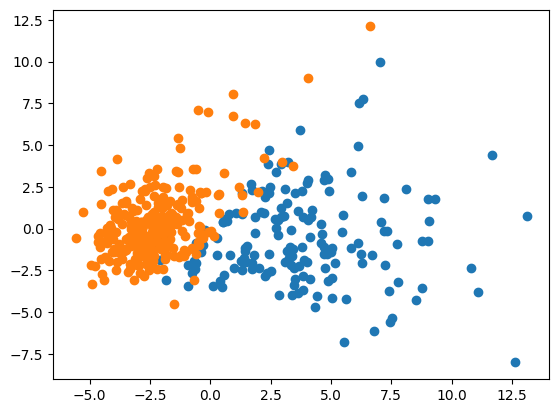

In [9]:
# n_components == 2 일 때만 실행 (보다 큰 수는 시각상 차이가 거의 없다)
plt.scatter(X_train_pca[y_train==0, 0], X_train_pca[y_train==0, 1])
plt.scatter(X_train_pca[y_train==1, 0], X_train_pca[y_train==1, 1])
plt.show()

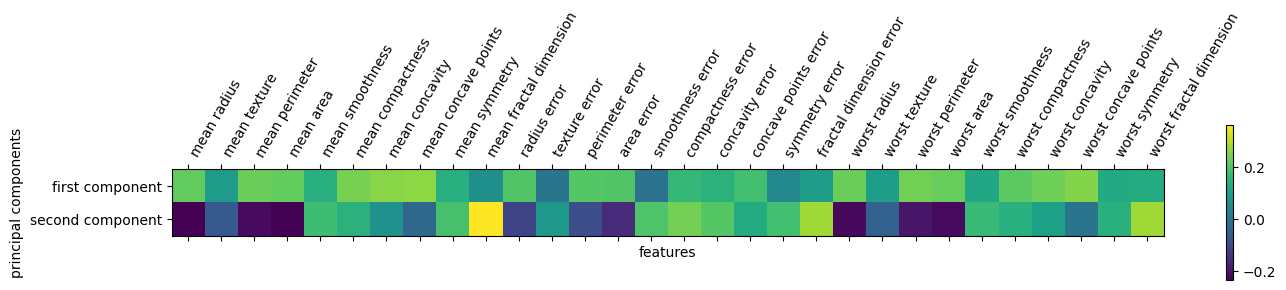

In [10]:
# 각 특성이 주성분에 얼마나 영향을 미치는지 정도의 시각화
# y축 주성분(2개), x축 특성
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["first component", "second component"])
plt.colorbar()
plt.xticks(range(len(bc_dataset['feature_names'])),
           bc_dataset['feature_names'], rotation=60, ha='left')
plt.xlabel("features")
plt.ylabel("principal components")
plt.show()

### 비음수 행렬 분해

In [11]:
# !pip install mglearn

##### 본 데이터

(2000, 3)


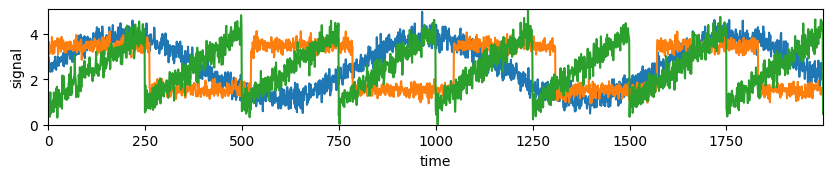

In [12]:
import mglearn
import mglearn.datasets

mglearn.datasets.make_signals()

S = mglearn.datasets.make_signals()
print(S.shape)
plt.figure(figsize=(10, 1.5))
plt.plot(S, '-')
plt.xlabel("time")
plt.ylabel("signal")
plt.margins(0)

##### 노이즈 섞기

In [13]:
# 노이즈 섞기

# 원본 데이터를 사용해 100개의 측정 데이터를 만듭니다
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("측정 데이터 형태:", X.shape)

측정 데이터 형태: (2000, 100)


##### 복원하기

In [14]:
# 노이즈 섞인 데이터 복원하기

from sklearn.decomposition import NMF

nmf = NMF(n_components=3, init='nndsvd', random_state=42, max_iter=1000, tol=1e-2)
S_ = nmf.fit_transform(X)
print("복원한 신호 데이터 형태:", S_.shape)

복원한 신호 데이터 형태: (2000, 3)


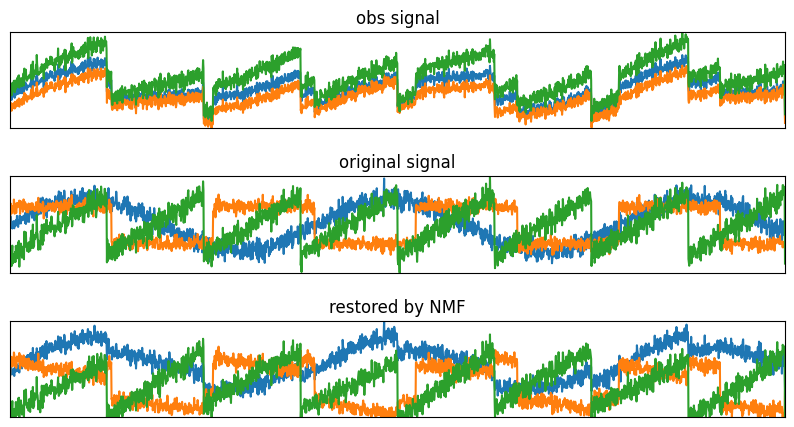

In [15]:
models = [X, S, S_,]
names = ['obs signal',      # 관측된 시그널(노이즈)
         'original signal', # 오리지널 시그널
         'restored by NMF'] # 복원된 시그널

fig, axes = plt.subplots(3, figsize=(10, 5), gridspec_kw={'hspace': .5},
                         subplot_kw={'xticks': (), 'yticks': ()})

for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')
    ax.margins(0)

### 군집 (Clustring)

In [24]:
# 데이터 준비
X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=2, random_state=42)

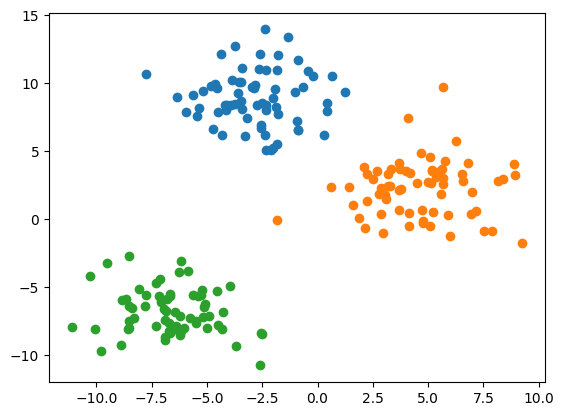

In [25]:
for t in np.unique(y):
    plt.scatter(X[y==t, 0], X[y==t, 1])

plt.show()

##### 군집화

In [47]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
clusters = kmeans.predict(X)
clusters

array([2, 3, 0, 4, 4, 0, 3, 4, 1, 0, 2, 2, 2, 2, 2, 4, 3, 4, 2, 0, 2, 2,
       0, 1, 0, 3, 3, 4, 1, 2, 2, 2, 4, 4, 3, 1, 0, 3, 0, 1, 2, 3, 4, 2,
       4, 2, 2, 0, 2, 1, 0, 3, 0, 1, 3, 3, 0, 2, 3, 2, 0, 3, 0, 0, 0, 0,
       3, 1, 0, 1, 1, 0, 3, 2, 1, 2, 2, 3, 1, 3, 1, 2, 2, 0, 4, 0, 4, 1,
       2, 4, 2, 3, 3, 1, 2, 4, 3, 2, 2, 1, 0, 4, 3, 4, 3, 2, 4, 2, 2, 4,
       2, 2, 1, 0, 3, 4, 0, 3, 3, 3, 0, 2, 3, 0, 4, 2, 3, 1, 2, 1, 2, 4,
       1, 4, 4, 2, 2, 2, 3, 2, 3, 3, 4, 2, 2, 3, 2, 0, 4, 2, 3, 0, 2, 4,
       2, 0, 4, 1, 2, 2, 3, 2, 2, 4, 3, 2, 2, 3, 0, 2, 0, 3, 2, 0, 1, 2,
       3, 3, 3, 2, 3, 2, 0, 0, 0, 1, 2, 2, 2, 3, 1, 2, 4, 4, 1, 4, 1, 1,
       2, 2], dtype=int32)

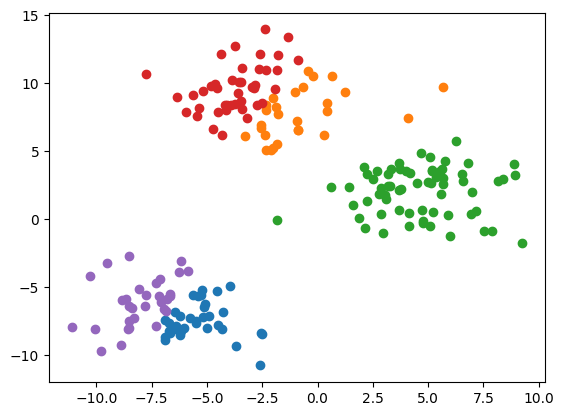

In [48]:
for t in np.unique(clusters):
    plt.scatter(X[clusters==t, 0], X[clusters==t, 1])

plt.show()

In [ ]:
print( kmeans.cluster_centers_ ) # 중심 확인
print( kmeans.labels_)  # 할당된 데이터

[[-5.36663674 -7.48780361]
 [-0.79739221  7.71834493]
 [ 4.61630775  2.0348944 ]
 [-3.73465911  9.64413804]
 [-8.01626781 -6.07194082]]
[2 3 0 4 4 0 3 4 1 0 2 2 2 2 2 4 3 4 2 0 2 2 0 1 0 3 3 4 1 2 2 2 4 4 3 1 0
 3 0 1 2 3 4 2 4 2 2 0 2 1 0 3 0 1 3 3 0 2 3 2 0 3 0 0 0 0 3 1 0 1 1 0 3 2
 1 2 2 3 1 3 1 2 2 0 4 0 4 1 2 4 2 3 3 1 2 4 3 2 2 1 0 4 3 4 3 2 4 2 2 4 2
 2 1 0 3 4 0 3 3 3 0 2 3 0 4 2 3 1 2 1 2 4 1 4 4 2 2 2 3 2 3 3 4 2 2 3 2 0
 4 2 3 0 2 4 2 0 4 1 2 2 3 2 2 4 3 2 2 3 0 2 0 3 2 0 1 2 3 3 3 2 3 2 0 0 0
 1 2 2 2 3 1 2 4 4 1 4 1 1 2 2]


##### 군집 평가 - 실루엣 스코어

In [ ]:
from sklearn.metrics import silhouette_score

scores = []
for n_clusters in np.arange(3, 6):   # 클러스터 갯수를 3, 4, 5에 대한 silhouette_score 계산
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    predicted_clusters = kmeans.predict(X)
    score = silhouette_score(X, predicted_clusters)
    scores.append(score)

In [53]:
scores

[np.float64(0.6947965016205384),
 np.float64(0.5730188258005171),
 np.float64(0.5590671215481356)]

##### 아이리스 데이터셋을 활용한 군집 및 평가

In [ ]:
from sklearn.datasets import load_iris

iris_dataset = load_iris()
X = iris_dataset['data']
y = iris_dataset['target']

kmeans = KMeans(n_clusters=5)   # 잘못된 군집 3개가 맞음
kmeans.fit(X)
predicted_clusters = kmeans.predict(X)

In [213]:
print( type(X) )    # numpy.ndarray
iris_with_cluster_df = pd.DataFrame(np.append(X, predicted_clusters.reshape((150, -1)), axis=1),
                                    columns=iris_dataset['feature_names'] + ['cluster'])
                                                            # 리스트 + 리스트 = 이어 붙이기

iris_with_cluster_df.head()

<class 'numpy.ndarray'>


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cluster
0,5.1,3.5,1.4,0.2,1.0
1,4.9,3.0,1.4,0.2,1.0
2,4.7,3.2,1.3,0.2,1.0
3,4.6,3.1,1.5,0.2,1.0
4,5.0,3.6,1.4,0.2,1.0


In [214]:
iris_with_cluster_df.groupby('cluster').mean()  # 군집으로 차별되면 좋은 군집

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
cluster,,,,
0.0,7.475000,3.125000,6.300000,2.050000
1.0,5.006000,3.428000,1.462000,0.246000
2.0,6.207692,2.853846,4.746154,1.564103
3.0,5.508000,2.600000,3.908000,1.204000
4.0,6.529167,3.058333,5.508333,2.162500
